## Implement and simulate RL model 

This notebook implements a basic RL model with a n-armed bandit task. 
The simulation should produce results that mimic the behavioral data including:

* trial: trial number in block
* stimulus: stimulus presented for this trial (1:x, x = set size)
* key_press: action for the trial (0 = J, 1 = K, 2 = L)
* key_answer: correct action for the trial (0 = J, 1 = K, 2 = L)
* correct: whether response was corect
* set_size: set size of this block
* set: image folder used for this block
* img_num: image file used for this trial's stimulus
* iteration: how many times this stimulus has been seen so far
* delay: how many trials since last presentation of this stimulus
* reward_history: how many correct responses for this stimulus since block start

This should also be able to look at the affects of various hyperparameters in the model including: 

* alpha (float between 0 and 1): learning rate
* beta (int): temperature
* epsilon (float between 0 and 1): noise
* phi (float between 0 and 1): decay
* pers (float between 0 and 1): perseveration, values closer to 1 have complete neglect of 
* negative feedback
* values near 0 represent equal learning from positive and negative learning


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import random

In [29]:
class simulate_RL6():
    def __init__(self, alpha, beta, epsilon, phi, pers, T, actions,reward):
        self.alpha = alpha
        self.pers = pers
        self.neg_alpha = (1-self.pers)*self.alpha
        self.beta = beta
        self.epsilon = epsilon
        self.phi = phi
        self.pers = pers
        self.T = T
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.reward = reward
        self.actions = actions
        self.Q = np.zeros((len(self.reward.keys()), self.actions))
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            
 
            set_size = len(self.reward.keys())
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
            
            p = np.exp(self.beta * self.Q[s, :])
            p= p/np.sum(p)
            p = (1-self.epsilon)*p + self.epsilon*(1/self.actions)
            a = random.choices(list(range(0, self.actions)), weights=p)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r=0

            Q0 = self.Q[s, a].copy()
            if r==0:
                self.Q[s,a] = self.Q[s,a] + self.neg_alpha*(r-self.Q[s,a])
               
            else:
                self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            self.Q[s,a] = self.Q[s, a] + self.phi*(Q0-self.Q[s, a])
            self.correct.append(r)
        
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        
    

In [30]:
class simulate_RLWM():
    """ This class includes the function for fitting a simulation of the RLWM task.
    It can also be used to train the model with the behavioral data. 
    
    Args:
    
    Alpha (float): learning rate bounded from 0 to 1
    K (int): working memory capacity
    prior (): working memory prior weight
    beta (int): inverse temperature average value is 5 . Fixed to 100
    epsilon (float): noise bounded from 0 to 1
    phi (float): decay bounded from 0 to 1
    pers (float): neglect of negative values bounded from 0 to 1
    T (int): number of trials per block
    actions (int): number of possible responses
    reward (dict): keys are the stimulus, values are the correct action response
    
    """
    def __init__(self, alpha, K, prior, beta, epsilon, phi, pers, T, actions,reward):
        self.alpha = alpha
        self.pers = pers
        self.beta = beta
        self.epsilon = epsilon
        self.phi = phi
        self.prior = prior
        self.K = K
        
        self.T = T
        self.reward = reward
        self.actions = actions
        
        self.Wwm = self.prior*(np.min([1, self.K/len(self.reward.keys())]))
        self.neg_alpha = (1-self.pers)*self.alpha
        
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.outcome = []
        self.Q = np.ones((len(self.reward.keys()), self.actions))/self.actions
        self.W = np.ones((len(self.reward.keys()), self.actions))/self.actions
        self.W0 = self.W.copy()
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            if i >=1:
                
                self.W = self.W + self.phi*(self.W0-self.W)


            set_size = len(self.reward.keys())
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
 
            Prl = np.exp(self.beta * self.Q[s, :])
            Prl = Prl/np.sum(Prl)
            
            Pwm = np.exp(self.beta * self.W[s, :])
            Pwm = Pwm/np.sum(Pwm)
            
            Pall = self.Wwm*Pwm + (1-self.Wwm)*Prl
            Pall = (1-self.epsilon)*Pall + self.epsilon*(1/self.actions)
            a = random.choices(list(range(0, self.actions)), weights=Pall)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r = 0
            self.outcome.append(r)
            if r==0:
                self.Q[s,a] = self.Q[s,a] + self.neg_alpha*(r-self.Q[s,a])
               
            else:
                self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            
            
            self.W[s,a] = r
            self.correct.append(r)
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        

In [31]:
class simulate_RL2():
    def __init__(self, alpha, beta, T, actions,reward):
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.correct = []
        self.key_answer = []
        self.stimulus = []
        self.reward = reward
        self.actions = actions
        self.Q = np.zeros((len(self.reward.keys()), self.actions))
    def fit(self):
        """This function will train the model
        """
        for i in range(0, self.T):
            
            set_size = len(self.reward.keys())
            
            s = np.random.randint(0, set_size)
            self.stimulus.append(s)
            
            p = np.exp(self.beta * self.Q[s, :])
            p= p/np.sum(p)
            
            a = random.choices(list(range(0, self.actions)), weights=p)[0]
            self.key_answer.append(a)
            correct = self.reward[s]
            if correct == a:
                r = 1
            else:
                r=0

            self.Q[s, a] = self.Q[s, a] + self.alpha*(r-self.Q[s, a])
            self.correct.append(r)
        
    def get_delay(self):
        if len(self.stimulus)==0:
            raise NameError("model not yet fit, please fit model")
        else:
            self.delay = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.delay.append(0)
                else:
                    biggest_idx = np.max(np.where(idx < j)[0])
                    self.delay.append(j-idx[biggest_idx])
        
    def get_iteration(self):
        if len(self.correct) == 0:
            print("model not yet fit please fit model")
        else:
            self.iteration = []
            for j, i in enumerate(self.stimulus):
                idx = np.where(np.array(self.stimulus)==i)[0]
                if j <= np.min(idx):
                    self.iteration.append(0)
                else:
                    self.iteration.append(len(np.where(idx<j)[0]))
    def get_reward_history():
        if len(self.correct)==0:
            print("model not yet fit, please fit model")
        else:
            pass
        
    

## Standard Parameters

In [5]:
alpha = 0.01
beta= 50
epsilon =0.1
phi=0.1
pers=0.1
T=110
actions = 3
K=2
prior=0.8
rewards = {0:1, 1:0}#, 2:1, 3:2, 4:2, 5:0}
model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, pers, T, actions, rewards)
model.fit()


### RLWM model

In [28]:
all_correct = dict()
all_correct = dict()
all_iter = dict()
for r in [{0:1, 1:0}, {0:1, 1:0, 2:1}, {0:1, 1:0, 2:1, 3:2}, {0:1, 1:0, 2:1, 3:2, 4:2}, {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}]:
    correct_x = []
    iter_x = []
    for x in range(50):
        model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, pers, T, actions, r)

        model.fit()
        model.get_iteration()
        correct_x.append(model.correct)
        iter_x.append(model.iteration)
    all_correct[len(r.keys())] = correct_x
    all_iter[len(r.keys())] = iter_x
    
all_set = {}
sem_set = {}

for i in range(2, 7):
    mean_iter = []
    sem_iter = []
    for  n in range(1, 14):
        just_iter = np.where(np.concatenate(np.array(all_iter[i]))==n)[0]
        test_result = np.array([i for j, i in enumerate(np.concatenate(np.array(all_correct[i]))) if j in just_iter])
        mean_iter.append(np.mean(test_result))
        sem_iter.append(scipy.stats.sem(test_result))
    all_set[i] = mean_iter
    sem_set[i] = sem_iter
        

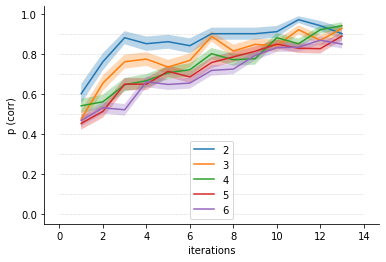

In [29]:
plt.figure()
ax = plt.subplot(111)

for i in range(2, 7):
    plt.plot(list(range(1, 14)), all_set[i], label=str(i))
    plt.fill_between(list(range(1, 14)), [i-j for i, j in zip(all_set[i], sem_set[i])], [i+j for i, j in zip(all_set[i], sem_set[i])], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14], [y/100]*3, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend()
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True) 

### RL2 model

In [6]:
all_correct = dict()
all_iter = dict()
for r in [{0:1, 1:0}, {0:1, 1:0, 2:1}, {0:1, 1:0, 2:1, 3:2}, {0:1, 1:0, 2:1, 3:2, 4:2}, {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}]:
    correct_x = []
    iter_x = []
    for x in range(100):
        model = simulate_RL2(alpha, beta, T, actions, r)
        model.fit()
        model.get_iteration()
        correct_x.append(model.correct)
        iter_x.append(model.iteration)
    all_correct[len(r.keys())] = correct_x
    all_iter[len(r.keys())] = iter_x

In [7]:
all_set = {}
sem_set = {}

for i in range(2, 7):
    mean_iter = []
    sem_iter = []
    for  n in range(1, 20):
        just_iter = np.where(np.concatenate(np.array(all_iter[i]))==n)[0]
        test_result = np.array([i for j, i in enumerate(np.concatenate(np.array(all_correct[i]))) if j in just_iter])
        mean_iter.append(np.mean(test_result))
        sem_iter.append(scipy.stats.sem(test_result))
    all_set[i] = mean_iter
    sem_set[i] = sem_iter
        

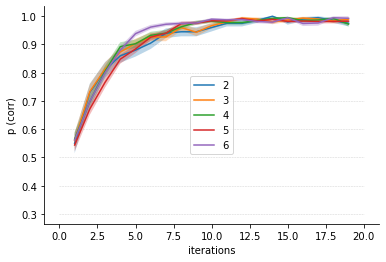

In [8]:
plt.figure()
ax = plt.subplot(111)

for i in range(2, 7):
    plt.plot(list(range(1, 20)), all_set[i], label=str(i))
    plt.fill_between(list(range(1, 20)), [i-j for i, j in zip(all_set[i], sem_set[i])], [i+j for i, j in zip(all_set[i], sem_set[i])], alpha=0.3)

for y in range(30, 100, 10):
     plt.plot([0, 8, 14, 20], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend()
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True) 

### RLWM model

In [30]:
all_correct = dict()
all_iter = dict()
for r in [{0:1, 1:0}, {0:1, 1:0, 2:1}, {0:1, 1:0, 2:1, 3:2}, {0:1, 1:0, 2:1, 3:2, 4:2}, {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}]:
    correct_x = []
    iter_x = []
    for x in range(100):
        model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, pers, T, actions, r)

        model.fit()
        model.get_iteration()
        correct_x.append(model.correct)
        iter_x.append(model.iteration)
    all_correct[len(r.keys())] = correct_x
    all_iter[len(r.keys())] = iter_x

In [31]:
all_set = {}
sem_set = {}

for i in range(2, 7):
    mean_iter = []
    sem_iter = []
    for  n in range(1, 20):
        just_iter = np.where(np.concatenate(np.array(all_iter[i]))==n)[0]
        test_result = np.array([i for j, i in enumerate(np.concatenate(np.array(all_correct[i]))) if j in just_iter])
        mean_iter.append(np.mean(test_result))
        sem_iter.append(scipy.stats.sem(test_result))
    all_set[i] = mean_iter
    sem_set[i] = sem_iter
        

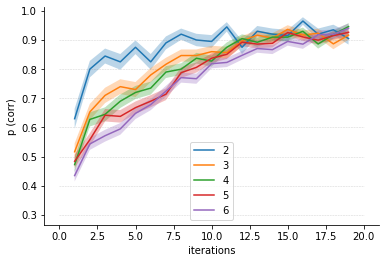

In [32]:
plt.figure()
ax = plt.subplot(111)

for i in range(2, 7):
    plt.plot(list(range(1, 20)), all_set[i], label=str(i))
    plt.fill_between(list(range(1, 20)), [i-j for i, j in zip(all_set[i], sem_set[i])], [i+j for i, j in zip(all_set[i], sem_set[i])], alpha=0.3)

for y in range(30, 100, 10):
     plt.plot([0, 8, 14, 20], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend()
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True) 

In [53]:
np.geomspace(0.01, 1, num=10)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

In [57]:
all_correct = dict()
all_sem = dict()
for a in np.geomspace(0.01, 1, num=10):
    correct = []
    correct_sem = []
    for i in range(100):
        model = simulate_RLWM(a, K, prior, beta, epsilon, phi, pers, T, actions, r)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(a)] = correct
    all_sem[str(a)] = correct_sem





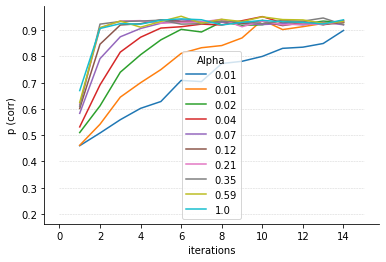

In [61]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=f'{i:.4}')
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(20, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Alpha')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [62]:
all_correct = dict()
all_sem = dict()
for b in np.geomspace(1, 100, num=10):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, K, prior, b, epsilon, phi, pers, T, actions, r)
        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(b)] = correct
    all_sem[str(b)] = correct_sem



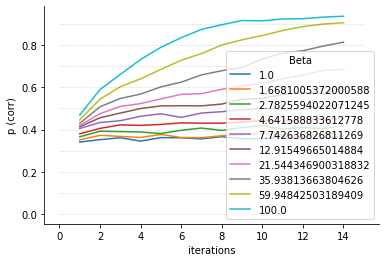

In [63]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Beta')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [67]:
all_correct = dict()
all_sem = dict()
for e in range (10, 100, 10):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, K, prior, beta, e/100, phi, pers, T, actions, r)

        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(e/100)] = correct
    all_sem[str(e/100)] = correct_sem

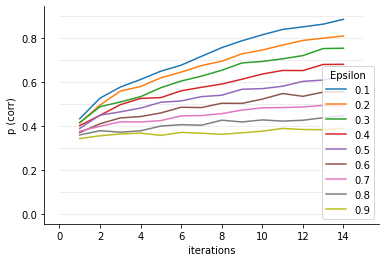

In [68]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='Epsilon')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [71]:
all_correct = dict()
all_sem = dict()
for p in np.geomspace(0.01, 1, num=10):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, K, prior, beta, epsilon, p, pers, T, actions, r)

        model.fit()
        model.get_delay()
        model.get_iteration()

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(p)] = correct
    all_sem[str(p)] = correct_sem

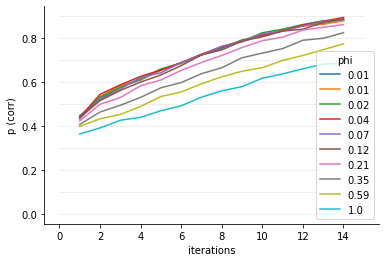

In [72]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=f'{i:.4}')
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='phi')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [77]:
all_correct = dict()
all_sem = dict()
for p in np.geomspace(0.01, 1, num=5):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, p, T, actions, r)

        model.fit()
        model.get_delay()
        model.get_iteration()
        if i ==1:
            print(model.neg_alpha)

        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(p)] = correct
    all_sem[str(p)] = correct_sem

0.0099
0.009683772233983163
0.009000000000000001
0.00683772233983162
0.0


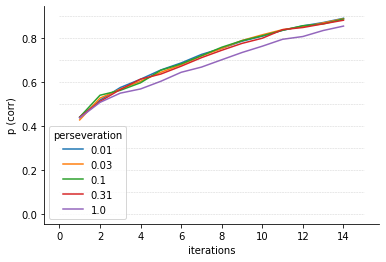

In [78]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=f'{i:.4}')
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='perseveration')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [82]:
all_correct = dict()
all_sem = dict()
#for p in np.geomspace(0.01, 1, num=5):
for p in range(10, 100, 10):
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, K, p/100, beta, epsilon, phi, pers, T, actions, r)

        model.fit()
        model.get_delay()
        model.get_iteration()
        
        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(p/100)] = correct
    all_sem[str(p/100)] = correct_sem

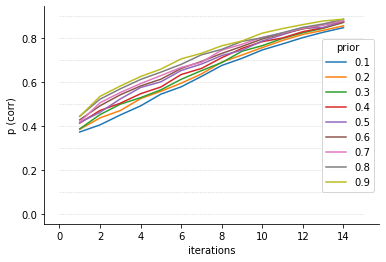

In [83]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=f'{i:.4}')
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='prior')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [84]:
all_correct = dict()
all_sem = dict()
#for p in np.geomspace(0.01, 1, num=5):
for k in [2, 3, 4, 5, 6]:
    correct = []
    correct_sem = []
    for i in range(1000):
        model = simulate_RLWM(alpha, k, prior, beta, epsilon, phi, pers, T, actions, r)

        model.fit()
        model.get_delay()
        model.get_iteration()
        
        all_iter = []
        sem_iter = []
        for n in range(1, 15):
            just_iter = np.where(np.array(model.iteration)==n)[0]
            test_result = np.array([i for j, i in enumerate(model.correct) if j in just_iter])
            all_iter.append(np.mean(test_result))
            sem_iter.append(scipy.stats.sem(test_result))
        correct.append(all_iter)
        correct_sem.append(sem_iter)
    all_correct[str(k)] = correct
    all_sem[str(k)] = correct_sem

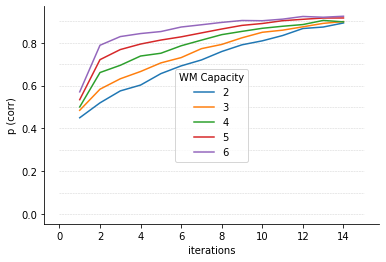

In [85]:
plt.figure()
ax = plt.subplot(111)

for i in all_correct.keys():
    plt.plot(list(range(1, 15)), np.mean(np.array(all_correct[i]), axis=0), label=i)
    #plt.fill_between(list(range(1, 15)), [i-j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], [i+j for i, j in zip(np.mean(np.array(all_correct[i]), axis=0), np.mean(np.array(all_sem[i]), axis=0))], alpha=0.3)

for y in range(0, 100, 10):
     plt.plot([0, 8, 14, 15], [y/100]*4, '--', lw=0.5, color='dimgray', alpha=0.3)

plt.legend(title='WM Capacity')
plt.xlabel('iterations')
plt.ylabel('p (corr)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

## Fitting the model parameters

In [32]:
from scipy.optimize import minimize
from load_data import load_clean_data


In [33]:
def optimize(fname, 
             bounds, 
             Data, 
             niter,
             toplot=False,
            ):
             


    outcomes = np.full([niter, len(bounds)+1], np.nan)
    optimcurve = np.full(niter, np.nan)
    for i in range(niter):
        
        # random starting point based on maximum bounds
        params0 = np.array([bound[1] * np.random.rand() for bound in bounds])
            
        # compute the function value at the starting point
        #llh0 = fname(params0, Data)
        
        # run the optimizer with constraints    
        result = minimize(fun=fname, x0=params0, args=Data, tol=1e-3, bounds=bounds)
        #result = minimize(fun, x0, bounds=bnds)
        x = result.x
        bestllh = fname(x, Data)
        #bestllh = fname(x)
        outcomes[i, :] = [bestllh] + [xi for xi in x]    
        optimcurve[i] = min(outcomes[:(i+1), 0])
        print(f'{(i/niter)*100}%', end='\r')

    # find the global minimum out of all outcomes
    i = np.argwhere(outcomes[:, 0] == np.min(outcomes[:, 0]))
    bestparameters = outcomes[i[0], 1:].flatten()
    bestllh = -outcomes[i[0], 0].flatten()[0]
    
    # plot the best llh found by the optimizer as a function of iteration number.
    if toplot:
        plt.figure()
        plt.plot(range(niter), np.round(optimcurve, 6), 'o-')
        plt.xlabel('iteration')
        plt.ylabel('best minimum')
        plt.title(str(nblocks) + ' blocks')
    
    return(bestparameters, bestllh)



In [34]:
""" 

Args:

Alpha (float): learning rate bounded from 0 to 1
K (int): working memory capacity
prior (): working memory prior weight
beta (int): inverse temperature average value is 5 . Fixed to 100
epsilon (float): noise bounded from 0 to 1
phi (float): decay bounded from 0 to 1
pers (float): neglect of negative values bounded from 0 to 1
T (int): number of trials per block
actions (array): all actions chosen per block
reward (array): all rewards recieved per block

"""

def likelihood_RLWM(actions, rewards, stimulus, set_size, K, alpha, prior, epsilon, phi, pers):
    """This function calculate the probability 
    """
    beta = 100
    action_options = 3
    T = len(actions)
    Wwm = prior*(np.min([1, K/set_size]))
    neg_alpha = (1-pers)*alpha
    Q = np.ones((6, action_options))/action_options
    W = np.ones((6, action_options))/action_options
    W0 = W.copy()
    choiceProb = []
    
    for a, r, s in zip(actions, rewards, stimulus):
      

        W = W + phi*(W0-W)



        Prl = np.exp(beta * Q[s, :])
        Prl = Prl/np.sum(Prl)

        Pwm = np.exp(beta * W[s, :])
        Pwm = Pwm/np.sum(Pwm)

        Pall = Wwm*Pwm + (1-Wwm)*Prl
        Pall = (1-epsilon)*Pall + epsilon*(1/action_options)

        choiceProb.append(Pall[a])

        if r==0:
            Q[s,a] = Q[s,a] + neg_alpha*(r-Q[s,a])

        else:
            Q[s, a] = Q[s, a] + alpha*(r-Q[s, a])


        W[s,a] = r
    NegLL = -np.sum(np.log(choiceProb))
    return NegLL




In [35]:
data = load_clean_data()


10.21 percent trials removed


In [36]:
# subj = 5
# subj_idx = np.where(data['subj']==subj)[0]
# test_blocks = np.unique([data['block'][i] for i in subj_idx])
# subj_reward = np.array([i for j, i in enumerate(data['correct']) if j in subj_idx])
# subj_action = np.array([i for j, i in enumerate(data['action']) if j in subj_idx])
# subj_stimulus = np.array([i-1 for j, i in enumerate(data['stimulus'])if j in subj_idx])
# subj_setsize = np.array([i for j, i in enumerate(data['set_size']) if j in subj_idx])[0]

# data = np.array([subj_action, subj_reward, subj_stimulus])



In [37]:
# Data should be action, reward, stimulus
fun = lambda x, Data : likelihood_RLWM(Data[0], Data[1], Data[2], set_size, K, x[0], x[1], x[2], x[3], x[4])


In [38]:
bnds = ((0, 1), (0, 1), (0,1), (0, 1), (0,1))
x0 = np.random.rand(5)


In [39]:
K = 4
x0 = np.random.rand(5)



In [40]:
x0



array([0.73047345, 0.54054025, 0.27692597, 0.49833214, 0.35880326])

In [41]:
alpha = 0.01
beta= 50
epsilon =0.1
phi=0.1
pers=0.1
T=110
actions = 3
K=4
set_size=6
prior=0.8
rewards = {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}


In [42]:
action = []
reward = []
stimulus = []

for i in range(10):
    model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, pers, T, actions, rewards)
    model.fit()
    
    action.append(model.key_answer)
    reward.append(model.outcome)
    stimulus.append(model.stimulus)
data = np.array([np.concatenate(action), np.concatenate(reward), np.concatenate(stimulus)])
print(data.shape)

(3, 1100)


NameError: name 'nblocks' is not defined

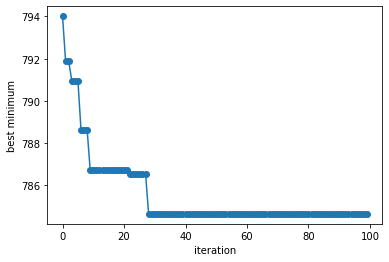

In [43]:
test= optimize(fun, bnds, data, niter=100, toplot=True)



In [44]:
#alpha, prior, epsilon, phi, pers
test

(array([0.91395149, 0.42324728, 0.25723862, 0.37316386, 0.39405853]),
 -711.9379614661352)

In [26]:
alpha, prior, epsilon, phi, pers = np.random.rand(5)

In [45]:
alphas = []
priors = []
epsilons = []
phis = []
perss = []
lalphas = []
lpriors = []
lepsilons = []
lperss = []
lphis=[]
for i in range(100):
    alpha, prior, epsilon, phi, pers = np.random.rand(5)
    alphas.append(alpha)
    priors.append(prior)
    epsilons.append(epsilon)
    phis.append(phi)
    perss.append(pers)
    beta= 50
    T=110
    actions = 3
    K=4
    set_size=6
    rewards = {0:1, 1:0, 2:1, 3:2, 4:2, 5:0}
    
    action = []
    reward = []
    stimulus = []

    for j in range(100):
        model = simulate_RLWM(alpha, K, prior, beta, epsilon, phi, pers, T, actions, rewards)
        model.fit()

        action.append(model.key_answer)
        reward.append(model.outcome)
        stimulus.append(model.stimulus)
    data = np.array([np.concatenate(action), np.concatenate(reward), np.concatenate(stimulus)])
    parameters, bestllh = optimize(fun, bnds, data, niter=20, toplot=False)
    lalpha, lprior, lepsilon, lphi, lpers = parameters
    lalphas.append(lalpha)
    lpriors.append(lprior)
    lepsilons.append(lepsilon)
    lphis.append(lphi)
    lperss.append(lpers)




In [56]:
np.save('alphas', alphas)
np.save('learned_alphas', lalphas)
np.save('priors', priors)
np.save('learned_priors', lpriors)
np.save('epsilons', epsilons)
np.save('learned_epsilons', lepsilons)
np.save('perseverations', perss)
np.save('learned_perseverations', lperss)
np.save('phis', phis)
np.save('learned_phis', lphis)


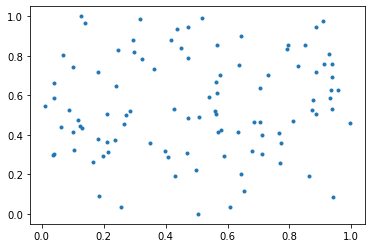

In [48]:
plt.plot(alphas, lalphas, '.')

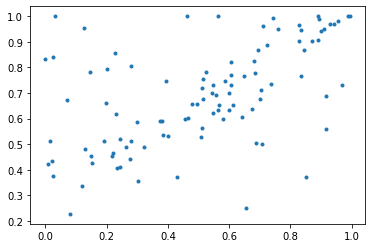

In [50]:
plt.plot(priors, lpriors, '.')

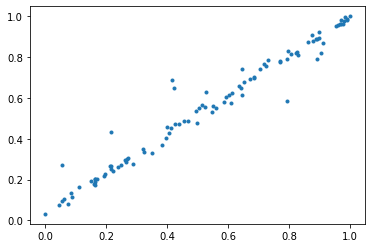

In [51]:
plt.plot(epsilons, lepsilons, '.')

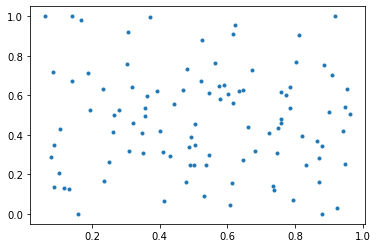

In [53]:
plt.plot(perss, lperss, '.')

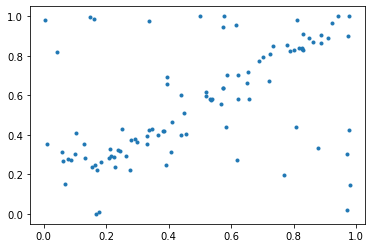

In [54]:
plt.plot(phis, lphis, '.')

In [46]:
import os
os.system('say "your program has finished"')

0

In [108]:
result = minimize(fun, x0, args=data, bounds=bnds)#, jac=jacobian)


#minimize(fun, x0, bounds=bnds, jac=jacobian)

